# Exploration of geosocial patterns (Germany)

<div style="width: 100%;text-align:right;display: flex; align-items: top;">
    <div style="float: left;width: 80%;text-align:left">
        <p><em><a href="mailto:a.dunkel@ioer.de">Alexander Dunkel</a>, Leibniz Institute of Ecological Urban and Regional Development, 
        Transformative Capacities & Research Data Centre (IÖR-FDZ)</em></p></div>
    <div style="width:256px;text-align:right;margin-top:0px;margin-right:10px"><a href="https://gitlab.hrz.tu-chemnitz.de/ad/geosocial_patterns_de"><img src="https://code.ad.ioer.info/wip/geosocial_patterns_de/version.svg"></a></div>
</div>

In [1]:
from IPython.display import Markdown as md
from datetime import date

today = date.today()
with open('/.version', 'r') as file: app_version = file.read().split("'")[1]
md(f"Last updated: {today.strftime('%b-%d-%Y')}, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version {app_version}")

Last updated: Aug-08-2024, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version 0.18.0

This is a project where I explore base geosocial media patterns for Germany

## Prepare environment

To run this notebook, as a starting point, you have two options:<br><br>

<div style="color: black;">
<details><summary style="cursor: pointer;"><strong>1.</strong> Create an environment with the packages and versions shown in the following cell.</summary>
   
As a starting point, you may use the latest conda <a href="https://gitlab.vgiscience.de/lbsn/tools/jupyterlab/-/blob/master-latest/environment_default.yml">environment_default.yml</a> from our CartoLab docker container.
<br><br>
</details>
</div>

<div style="color: black;">
<details><summary style="cursor: pointer;"><strong>2.</strong> If docker is available to you, we suggest to use the <a href="https://gitlab.vgiscience.de/lbsn/tools/jupyterlab">Carto-Lab Docker Container</a></summary>

Clone the repository and edit your <code>.env</code> value to point to the repsitory, where this notebook can be found, e.g.:
        
```bash
git clone https://gitlab.vgiscience.de/lbsn/tools/jupyterlab.git
cd jupyterlab
cp .env.example .env
nano .env
## Enter:
# JUPYTER_NOTEBOOKS=~/notebooks/geosocial_patterns_de
# TAG=v0.12.3
docker network create lbsn-network
docker-compose pull && docker-compose up -d
```

</details>
</div>

In [1]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.base import tools

root_packages = [
    'python', 'geopandas', 'pandas', 'matplotlib', 'dask', 'datashader']
tools.package_report(root_packages)

package,python,dask,datashader,geopandas,matplotlib,pandas
version,3.12.4,2024.7.1,0.16.3,1.0.1,3.9.1,2.2.2


Load dependencies:

In [1]:
import os
from pathlib import Path
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from IPython.display import clear_output, display, HTML

Activate autoreload of changed python files:

In [2]:
%load_ext autoreload
%autoreload 2

### Parameters

Define initial parameters that affect processing

In [3]:
OUTPUT = Path.cwd().parents[0] / "out"
OUTPUT.mkdir(exist_ok=True)

In [4]:
(Path.cwd().parents[0] / "notebooks").mkdir(exist_ok=True)
(Path.cwd().parents[0] / "py").mkdir(exist_ok=True)

In [5]:
CHUNK_SIZE = 5000000 

## Create notebook HTML

In [6]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import dask.diagnostics as diag
import datashader.transfer_functions as tf
import datashader as ds
from datashader.utils import lnglat_to_meters
from IPython.display import clear_output
from pathlib import Path

In [7]:
filename = Path.cwd().parents[0] / 'data' / '2024-07-31_DE_All_exportAllLatLng.csv'
dtypes = {'latitude': float, 'longitude': float}

In [9]:
%%time
parquet_output = OUTPUT / "twitter_proj.snappy.parq"
if not parquet_output.exists():
    iter_csv = pd.read_csv(
        filename, iterator=True,
        dtype=dtypes, encoding='utf-8', chunksize=CHUNK_SIZE)

    cnt = 0

    for ix, chunk in enumerate(iter_csv):
        # read
        append=True
        cnt += CHUNK_SIZE
        clear_output(wait=True)
        print(f"Processed {cnt:,.0f} coordinates..")
        if ix==0:
            if parquet_output.exists():
                break
            append=False
        dd_chunk = dd.from_pandas(chunk, npartitions=1)
        # project
        web_mercator_x, web_mercator_y = lnglat_to_meters(
            chunk['longitude'], chunk['latitude'])
        projected_coordinates = dd.concat(
            [web_mercator_x, web_mercator_y], axis=1)
        transformed = projected_coordinates.rename(
            columns={'longitude':'x', 'latitude': 'y'})
        # store
        dd.to_parquet(transformed, parquet_output, append=append, compression="SNAPPY")

Processed 70,000,000 coordinates..
CPU times: user 20.4 s, sys: 2.96 s, total: 23.4 s
Wall time: 23.4 s


In [10]:
datasize = sum(f.stat().st_size for f in parquet_output.glob('**/*') if f.is_file())/(1024*1024*1024)
print(
    f"Size: {datasize:,.1f} GB")

Size: 0.5 GB


In [11]:
df = dask.dataframe.read_parquet(parquet_output)
if datasize < 8:
    df = df.persist()

In [12]:
df.columns

Index(['x', 'y'], dtype='object')

In [13]:
df.head()

,x,y
0,1.483521e+06,6.891437e+06
1,7.615500e+05,6.609943e+06
2,1.491849e+06,6.896486e+06
3,9.711956e+05,6.063937e+06
4,7.902371e+05,6.540994e+06


In [76]:
def bounds(x_range, y_range):
    x,y = lnglat_to_meters(x_range, y_range)
    return dict(x_range=x, y_range=y)

Earth       = ((-180.00, 180.00), (-59.00, 74.00))
France      = (( -12.00,  16.00), ( 41.26, 51.27))
Berlin      = (( 12.843018,  14.149704), ( 52.274880, 52.684292))
Dresden     = (( 13.415680,  14.703827), ( 50.740090, 51.194905))
USA         = (( -126,  -64), ( 24.92, 49.35))
Paris       = ((   2.05,   2.65), ( 48.76, 48.97))
DE          = ((   4.605469,   15.372070), ( 46.697243, 55.065885))

In [55]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds(*Earth))

In [56]:
with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    agg = cvs.points(df, x='x', y='y')

[########################################] | 100% Completed | 102.74 ms


In [73]:
def plot(x_range, y_range, plot_width: int = None):
    """Plot df using tf-shade()
    Calculates aspect ratio based on 
    web mercator distance ratio lat/lng
    """
    if plot_width is None:
        plot_width = 1000
    lng_width = x_range[1]-x_range[0]
    lat_height = y_range[1]-y_range[0]
    plot_height = int(((plot_width * lat_height) / lng_width)*1.5)
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds(x_range, y_range))
    with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
        agg = cvs.points(df, x='x', y='y')
    return tf.shade(agg, cmap=["lightblue","darkblue"])

def save_image(img, output_name, return_img: bool = True, ):
    """Saves image as PNG"""
    ds.utils.export_image(
        img=img, filename= str(OUTPUT / output_name), fmt=".png", background='white')
    if return_img:
        return img

[########################################] | 100% Completed | 204.29 ms
CPU times: user 703 ms, sys: 397 ms, total: 1.1 s
Wall time: 740 ms


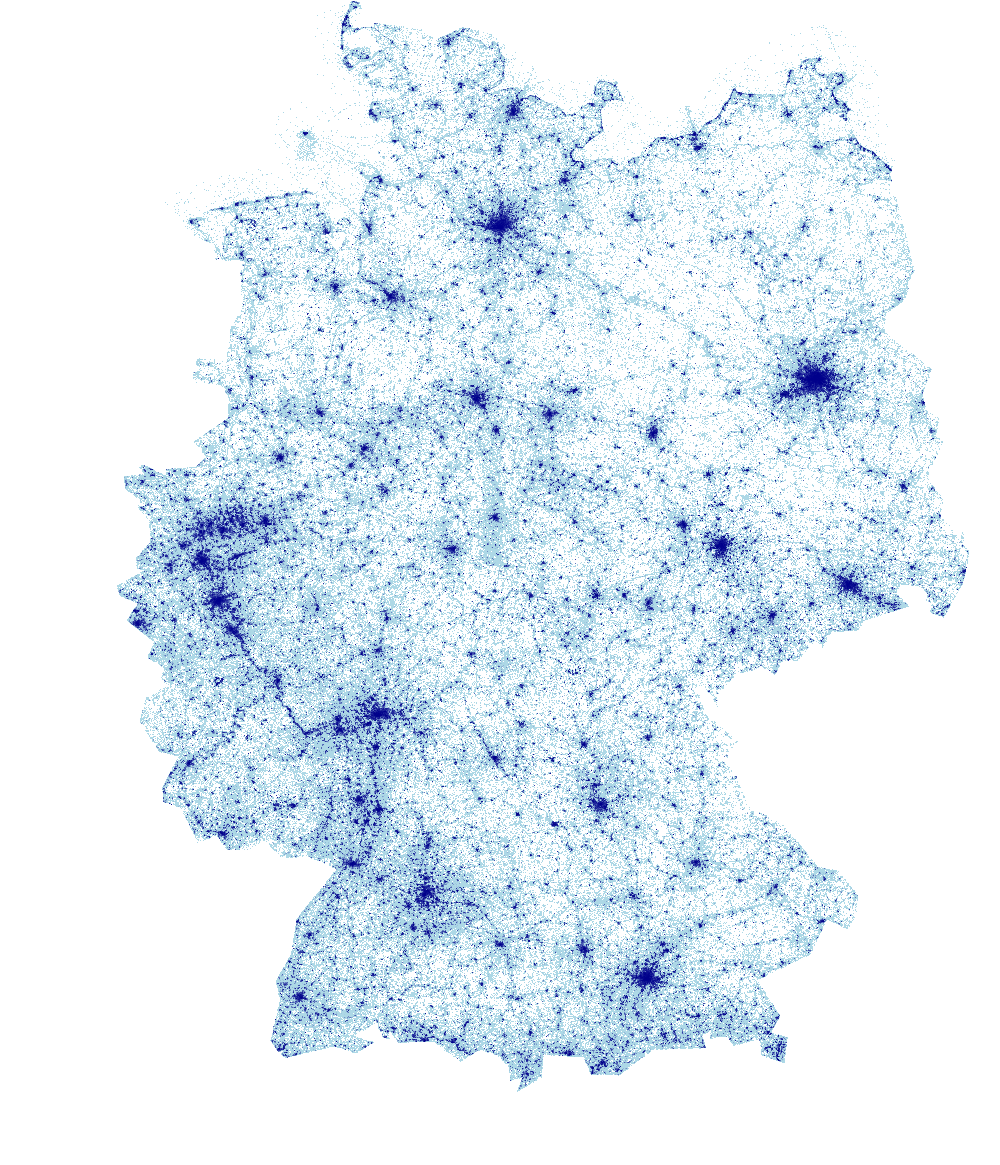

In [74]:
%time save_image(plot(*DE), output_name='DE_map')

[########################################] | 100% Completed | 103.02 ms
CPU times: user 350 ms, sys: 190 ms, total: 541 ms
Wall time: 610 ms


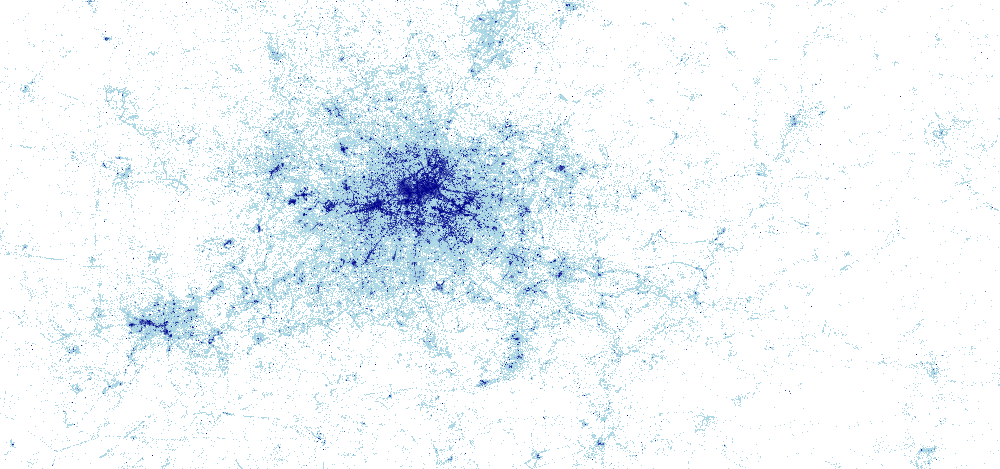

In [75]:
%time  save_image(plot(*Berlin), output_name='Berlin_map')

[########################################] | 100% Completed | 102.91 ms
CPU times: user 301 ms, sys: 220 ms, total: 522 ms
Wall time: 592 ms


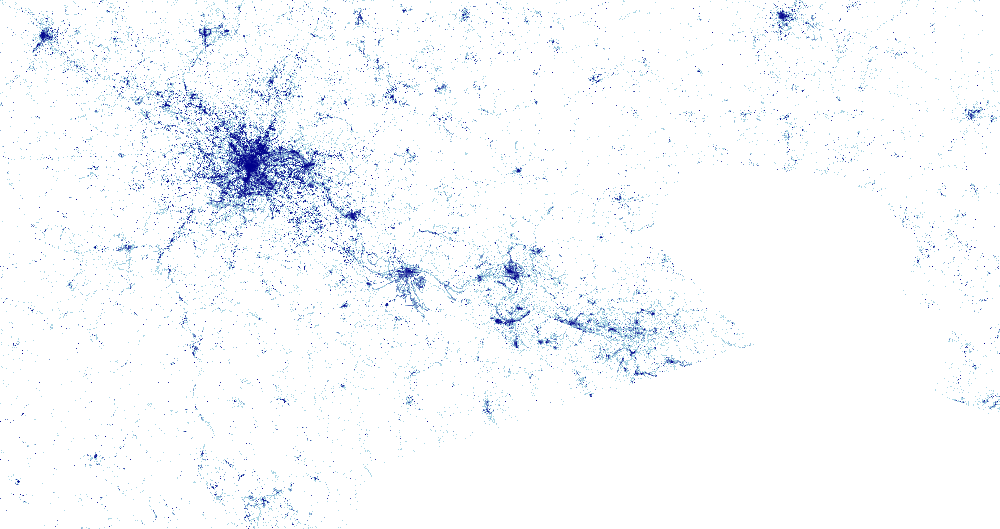

In [77]:
%time  save_image(plot(*Dresden), output_name='Dresden_map')

In [1]:
!jupyter nbconvert --to html_toc \
    --output-dir=../resources/html/ ./01_overview_de.ipynb \
    --template=../nbconvert.tpl \
    --ExtractOutputPreprocessor.enabled=False >&- 2>&- # create single output file